- This notebook is to show Entropy metrics for active learning

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import differential_entropy, norm
from scipy.stats import multivariate_normal

import numpy as np
import ot
import ot.plot

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

# PCA decomposition
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import pandas as pd

from sklearn.neighbors import KernelDensity
from scipy.stats import wasserstein_distance

In [9]:
import pickle

In [3]:
myfile =r'../Data/CombinedPSP.csv'
df_load = pd.read_csv(myfile)

df_load['JSC']=df_load['JSC'].abs()
df_reduce=df_load.iloc[:,3:]
df_refine=df_reduce.iloc[:,np.r_[0:3,4:23]]
df_refine

,JSC,ABS_f_D,DISS_wf10_D,STAT_e,STAT_n_D,STAT_n_A,STAT_CC_D,STAT_CC_A,STAT_CC_D_An,STAT_CC_A_Ca,...,CT_f_e_conn,CT_f_conn_D_An,CT_f_conn_A_Ca,CT_e_conn,CT_e_D_An,CT_e_A_Ca,CT_f_D_tort1,CT_f_A_tort1,CT_n_D_adj_An,CT_n_A_adj_Ca
0,60.626,0.494161,0.455724,2402,20014,20487,10,8,4,4,...,0.529559,0.639502,0.907551,1272,1533,2156,0.353934,0.268703,145,176
1,60.143,0.499395,0.429118,2227,20226,20275,7,9,2,3,...,0.333633,0.691437,0.668508,743,1533,1454,0.390204,0.332153,147,174
2,57.374,0.497914,0.400567,2053,20166,20335,9,7,4,4,...,0.531417,0.679163,0.875387,1091,1370,1785,0.457068,0.326105,155,185
3,51.381,0.495617,0.379442,1933,20073,20428,9,7,4,4,...,0.538024,0.684452,0.880948,1040,1301,1684,0.507242,0.351967,157,180
4,48.672,0.491198,0.340753,1723,19894,20607,10,6,5,4,...,0.603018,0.700010,0.930169,1039,1186,1586,0.587606,0.351263,174,164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1703,40.300,0.376040,0.367105,1730,15230,25271,17,1,4,1,...,0.154913,0.160210,1.000000,268,262,1776,1.000000,0.418978,133,229
1704,38.300,0.375645,0.355383,1632,15214,25287,15,1,4,1,...,0.166667,0.165966,1.000000,272,266,1670,1.000000,0.425476,133,228
1705,33.400,0.375003,0.337699,1532,15188,25313,14,1,4,1,...,0.172977,0.163682,1.000000,265,258,1566,1.000000,0.415873,130,225
1706,21.500,0.373620,0.317051,1403,15132,25369,11,1,3,1,...,0.132573,0.114922,1.000000,186,181,1430,1.000000,0.442233,93,247


In [4]:
x = df_refine.values #returns a numpy array
standard_scaler = preprocessing.StandardScaler()
x_scaled = standard_scaler.fit_transform(x)
df_refine_standardize = pd.DataFrame(x_scaled)
df_refine_standardize.columns=df_refine.columns
df_refine_standardize

,JSC,ABS_f_D,DISS_wf10_D,STAT_e,STAT_n_D,STAT_n_A,STAT_CC_D,STAT_CC_A,STAT_CC_D_An,STAT_CC_A_Ca,...,CT_f_e_conn,CT_f_conn_D_An,CT_f_conn_A_Ca,CT_e_conn,CT_e_D_An,CT_e_A_Ca,CT_f_D_tort1,CT_f_A_tort1,CT_n_D_adj_An,CT_n_A_adj_Ca
0,-0.485075,1.320169,0.087262,-0.006062,1.320161,-1.320161,-0.614829,1.114886,-0.824615,0.924866,...,1.109499,0.752834,-0.039552,1.454934,0.890408,-0.067287,-1.242632,-0.543406,-1.214708,-0.819939
1,-0.499940,1.444165,-0.087533,-0.157241,1.444167,-1.444167,-0.779685,1.377647,-1.481384,0.352936,...,-0.020990,0.949669,-1.491452,0.064221,0.890408,-0.643667,-1.111462,-0.149221,-1.168102,-0.872776
2,-0.585163,1.409079,-0.275106,-0.307555,1.409071,-1.409071,-0.669781,0.852126,-0.824615,0.924866,...,1.120220,0.903150,-0.234910,0.979095,0.650772,-0.371898,-0.869648,-0.186794,-0.981680,-0.582170
3,-0.769611,1.354663,-0.413892,-0.411220,1.354672,-1.354672,-0.669781,0.852126,-0.824615,0.924866,...,1.158342,0.923195,-0.201134,0.845019,0.549332,-0.454824,-0.688194,-0.026125,-0.935074,-0.714264
4,-0.852987,1.249975,-0.668069,-0.592634,1.249969,-1.249969,-0.614829,0.589365,-0.496230,0.924866,...,1.533357,0.982160,0.097825,0.842390,0.380264,-0.535288,-0.397559,-0.030499,-0.538926,-1.136963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1703,-1.110655,-1.478167,-0.494943,-0.586587,-1.478165,1.478165,-0.230167,-0.724438,-0.824615,-0.790924,...,-1.052201,-1.063688,0.521964,-1.184528,-0.978161,-0.379287,1.093861,0.390183,-1.494342,0.580252
1704,-1.172210,-1.487525,-0.571953,-0.671247,-1.487524,1.487524,-0.340070,-0.724438,-0.824615,-0.790924,...,-0.984381,-1.041872,0.521964,-1.174013,-0.972280,-0.466319,1.093861,0.430552,-1.494342,0.553834
1705,-1.323019,-1.502734,-0.688133,-0.757635,-1.502733,1.502733,-0.395022,-0.724438,-0.824615,-0.790924,...,-0.947972,-1.050529,0.521964,-1.192415,-0.984042,-0.551709,1.093861,0.370893,-1.564251,0.474578
1706,-1.689269,-1.535498,-0.823785,-0.869075,-1.535489,1.535489,-0.559878,-0.724438,-1.153000,-0.790924,...,-1.181102,-1.235330,0.521964,-1.400102,-1.097244,-0.663372,1.093861,0.534655,-2.426456,1.055789


In [5]:
def PCA_decomposition(df):
    X = df.iloc[:, 0:-1]

    pca=PCA()
    pca.fit(X)
    pca_data=pca.transform(X)

    per_var=np.round(pca.explained_variance_ratio_*100,decimals=1)
    print(f'Variance explained: {per_var}')
   
    return pca_data,pca

In [6]:
X = df_refine_standardize.loc[:,['STAT_e', 'DISS_f10_D', 'CT_n_D_adj_An', 'CT_n_A_adj_Ca', 'DISS_wf10_D']]    
y = df_refine_standardize.loc[:,['JSC']]   

In [7]:
dataPoolL0 = pd.concat([X,y], axis=1)

In [11]:
def load_pickle_data(file_path):
    # Load the .pkl file
    with open(file_path, 'rb') as file:
        load_data = pickle.load(file)
        
    return load_data

In [12]:
load_data1 = load_pickle_data('../Results_Data/Random_results_data_2023-12-29_10-21-38.pkl')
load_data2 = load_pickle_data('../Results_Data/Uncertainty_results_data_2023-12-29_13-47-17.pkl')
load_data3 = load_pickle_data('../Results_Data/GSx_results_data_2023-12-29_15-56-53.pkl')
load_data4 = load_pickle_data('../Results_Data/GSy_results_data_2023-12-29_21-00-15.pkl')
load_data5 = load_pickle_data('../Results_Data/iGS_results_data_2023-12-30_16-13-33.pkl')

In [13]:
dataPoolL1 = np.array(load_data1['SelectData1'])
dataPoolL2 = np.array(load_data2['SelectData1'])
dataPoolL3 = np.array(load_data3['SelectData1'])
dataPoolL4 = np.array(load_data4['SelectData1'])
dataPoolL5 = np.array(load_data5['SelectData1'])

In [ ]:
'''
Entropy calculation for a continuous probability density function is given by formula:
H = - ∫ p(x) log p(x) dx
This is estimate by:
H ≈ - 1/N ∑ log(p(x_i))
where p(x_i) is the estimated probability density at data point x_i, and N is the number of data points.

This approximation is as follows:
The formula H ≈ - ∫ p_hat(x) log(p_hat(x)) dx is an approximation of the true entropy formula 
H = - ∫ p(x) log(p(x)) dx for a continuous probability density function p(x), 
where p_hat(x) is the estimated density obtained through kernel density estimation (KDE).

H ≈ - ∫ p_hat(x) log(p_hat(x)) dx = - E[log(p_hat(X))]
where E[log(p_hat(X))] is the expected value of log(p_hat(X)) 
over the random variable X that represents the sample of data points {x_1, x_2, ..., x_N}.

We can estimate this expected value using the law of large numbers, 
which states that the average of a large number of independent random variables converges to their expected value. 
Specifically, we have:

E[log(p_hat(X))] ≈ 1/N ∑ log(p_hat(x_i))
'''

In [22]:
def Check_metric(budget):
#     metrics1=metrics
    pca_data,pca_model = PCA_decomposition(dataPoolL0)
    p0 = pca_data
    p0=p0[:,0:3]
    
    def entropy(data):

        # Estimate the density of the data using KDE
        kde = KernelDensity(kernel='gaussian', bandwidth='scott').fit(data)

        # Evaluate the estimated density at the data points
        log_dens = kde.score_samples(data)

        # Calculate the entropy of the estimated density
        ent = -np.mean(log_dens)

        return ent
    #calculating the entropy for whole data set
    e0=entropy(p0)
    
    
    def distribution_distance(dataPoolL,p0,method,runs=20,pc=0):
    # Calculating distribution    
        p=[]
        P=[]
        
        for run in range(runs):
            p=[]
            df = pd.DataFrame(dataPoolL[run])
            for i,c in enumerate(np.arange(10,budget,1)):# change later
                pca_data= pca_model.transform(df.iloc[0:c,0:-1])
                pca_data=pca_data[:,0:3]
                p.append(pca_data)
            P.append(p)

        # Calculating distance for distribution
        Distance=np.zeros((1,budget-10))
        KL = np.zeros((1,budget-10))
        Distance_average=np.zeros((20,budget-10))
        KL_average = np.zeros((20,budget-10))
        for i in range(len(P)):
            p = P[i]
            for j in range(len(p)):
                
                distance=entropy(p[j])

                Distance[0][j]=distance

            Distance_average[i]=np.array(Distance)
        W_distance = np.mean(Distance_average, axis=0)
        W_distance_std = np.std(Distance_average, axis=0)

        return W_distance, W_distance_std

    

    Distance_RS,Distance_RS_std = distribution_distance(dataPoolL1, p0, method='Random sampling')

    Distance_US,Distance_US_std = distribution_distance(dataPoolL2, p0, method='Uncertainty sampling')

    Distance_GSx,Distance_GSx_std = distribution_distance(dataPoolL3, p0, method='GSx')

    Distance_GSy,Distance_GSy_std = distribution_distance(dataPoolL4, p0, method='GSy')

    Distance_iGS,Distance_iGS_std = distribution_distance(dataPoolL5, p0, method='iGS')

    # # euclidean
    # plt.plot(np.arange(10, budget, 1), Distance_RS, label='Random sampling')
    # plt.fill_between(np.arange(10, budget, 1), Distance_RS - Distance_RS_std, 
    #                  Distance_RS + Distance_RS_std, alpha=0.2)

    # plt.plot(np.arange(10, budget, 1), Distance_US, label='Uncertainty sampling')
    # plt.fill_between(np.arange(10, budget, 1), Distance_US - Distance_US_std, 
    #                  Distance_US + Distance_US_std, alpha=0.2)

    # plt.plot(np.arange(10, budget, 1), Distance_GSx, label='GSx')
    # plt.fill_between(np.arange(10, budget, 1), Distance_GSx - Distance_GSx_std, 
    #                  Distance_GSx + Distance_GSx_std, alpha=0.2)

    # plt.plot(np.arange(10, budget, 1), Distance_iGS, label='iGS')
    # plt.fill_between(np.arange(10, budget, 1), Distance_iGS - Distance_iGS_std, 
    #                  Distance_iGS + Distance_iGS_std, alpha=0.2)

    # plt.plot(np.arange(10, budget, 1), Distance_GSy, label='GSy')
    # plt.fill_between(np.arange(10, budget, 1), Distance_GSy - Distance_GSy_std, 
    #                  Distance_GSy + Distance_GSy_std, alpha=0.2)
    
    # plt.hlines(y=e0,label='Etropy for all data',color='k',xmin=10, xmax=500, linestyle='--')


    # plt.legend()
    # plt.xlabel('Iterations')
    # plt.ylabel('Entropy')
    # # plt.title(f'{method}')
    # # plt.ylim(0,0.055)
    # plt.show()

    return Distance_RS,Distance_RS_std, Distance_US,Distance_US_std, Distance_GSx,Distance_GSx_std, Distance_GSy,Distance_GSy_std, \
        Distance_iGS,Distance_iGS_std,e0

In [23]:
d1, s1, d2, s2, d3, s3, d4, s4, d5, s5,e0 = Check_metric(budget=500)

Variance explained: [57.4 22.9 16.9  2.7  0.1]


In [24]:
filename='Results_entropy'

In [30]:
def plot_curves(d1, d2, d3, d4, d5, s1, s2, s3, s4, s5, e0, filename):
    fig, ax = plt.subplots()

    # offset = 10
    error_freq = 30
    
    # List of your datasets and their corresponding standard deviation arrays
    datasets = [d1, d2, d3, d4, d5]
    std_devs = [s1, s2, s3, s4, s5]
        
    labels = ['Random sampling', 'Uncertainty sampling', 'GSx', 'GSy', 'iGS']
    # colors = ['blue', 'orange', 'green', 'purple', 'red']
    tableau_colors = plt.get_cmap('tab10').colors[:5]
    # Shift 4th and 5th colors to the first two positions
    shifted_colors = tableau_colors[:3] + tableau_colors[4:5] + tableau_colors[3:4] 
    offsets = [10, 20, 30, 40, 50]
    
    for i, (dataset, std_dev, label, color, offset) in enumerate(zip(datasets, std_devs, labels, shifted_colors, offsets)):
        y = dataset
        e = std_dev
        x = np.arange(len(y))
        p = ax.plot(x+10, y, label=label, color=color)
    
        xe, ye, ee = (x+10)[offset::error_freq], y[offset::error_freq], e[offset::error_freq]
        xe, ye, ee = xe.flatten(), ye.flatten(), ee.flatten()
        ax.errorbar(xe, ye, yerr=ee, alpha=0.3, ls='none', ecolor=p[0].get_color(), elinewidth=2, capsize=3, capthick=2)
        offset += error_freq
    
    plt.hlines(y=e0,label='Etropy for all data',color='k',xmin=10, xmax=500, linestyle='--')
    
    plt.xlabel('Number of samples')
    plt.ylabel('Entropy')
    plt.legend()
    plt.savefig(filename, dpi=200)
    plt.show()

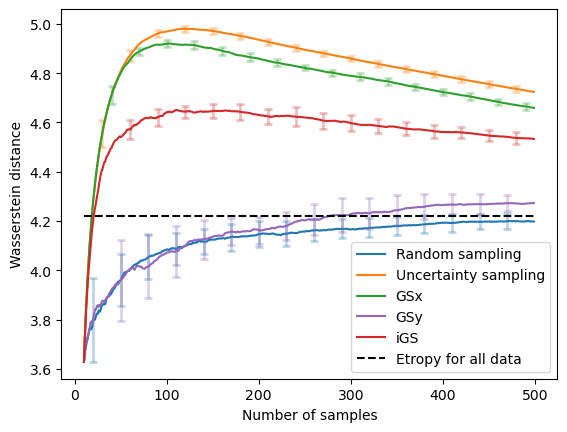

In [31]:
plot_curves(d1, d2, d3, d4, d5, s1, s2, s3, s4, s5, e0,filename)